# Imports and Setup:

In [35]:
import os
import sys
sys.path.append("../")

import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
import numpy as np
import random
from einops import rearrange
from torch.utils.data import DataLoader
from torchvision.transforms import v2

import utils
from model import MAE_ViT, MAE_Encoder, MAE_Decoder, MAE_Encoder_FeatureExtractor

import warnings
warnings.filterwarnings('ignore')

# Load the Pretrained Model:

In [36]:
# define the model, dataset and pca mode
config_file_path = "../config/config_file.yaml"
cfg = utils.load_yaml(config_file_path)
dataset_name = "cifar10"
pca_mode = "no_mode"
model_name = "vit-t-mae-pretrain.pt"
folder_name = f"../model/{dataset_name}/{pca_mode}"
model_path = f"{folder_name}/{model_name}"
mask_ratio = 0.75
model = torch.load(model_path, map_location='cpu')
model.eval()
device = utils.get_gpu() # get the gpu if available
utils.setup_seed(12345) # set seed
model.to(device)

# create a folder to save the model if it does not exist
folder_name = f"../images/model_results"
os.makedirs(folder_name, exist_ok=True)

Tesla V100-PCIE-32GB
Memory Usage:
Allocated: 3.0 GB
Cached:    5.5 GB
1 Number of Devices Exists


# Load Validation Dataset:

In [37]:
root_path = f"../data/{dataset_name}"
transform = v2.Compose([
        v2.Resize((32, 32)),
        v2.ToTensor(), 
        v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    ])

train_dataset, val_dataset = utils.load_and_preprocess_images(root_path, dataset_name, transform, transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

Files already downloaded and verified


# Compute Validation Loss:

In [38]:
val_loss = 0
with torch.no_grad():
    for val_img, _ in val_dataloader:
        val_img = val_img.to(device)
        predicted_val_img, mask = model(val_img)
        loss = torch.mean((predicted_val_img - val_img) ** 2 * mask) / mask_ratio
        val_loss += loss.item()
val_loss /= len(val_dataloader)
print(f"Validation Loss: {val_loss:.4f}")

Validation Loss: 0.0315


# Visualize the Predictions from a Single Batch (NO PCA Mode)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


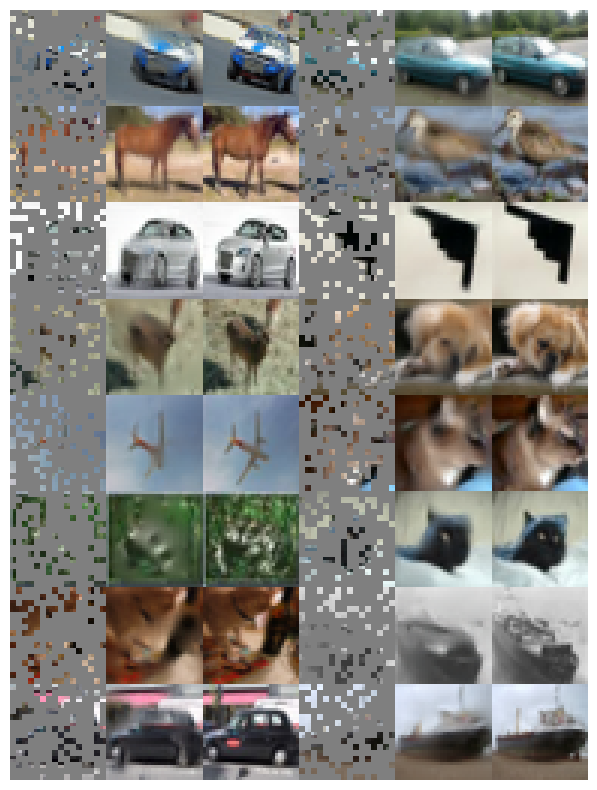

In [39]:
# # Visualize the first batch
# val_img, _ = next(iter(val_dataloader))

# Visiualize the random batch
total_batches = len(val_dataloader)
random_index = random.randint(0, total_batches - 1)

# Retrieve the random batch
for i, (batch, label) in enumerate(val_dataloader):
    if i == random_index:
        val_img = batch
        break

val_img = val_img.to(device)
predicted_val_img, mask = model(val_img)
# MAE reconstruction pasted with visible patches
predicted_val_img = predicted_val_img * mask + val_img * (1 - mask) 

img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img], dim=0)
img = rearrange(img, "(v h1 w1) c h w -> c (h1 h) (w1 v w)", w1=2, v=3)

img = (
    img.cpu().detach().numpy().transpose(1, 2, 0) + 1
) / 2  # Normalize to [0, 1] for display

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
# plt.show()
plt.savefig(f"{folder_name}/mae_visualize.png")

# Visualize the Predictions from a Single Image:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


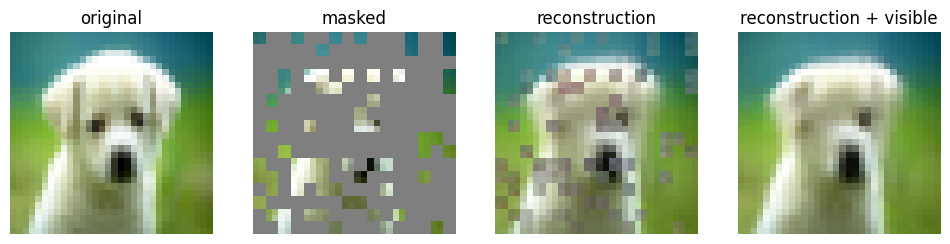

In [40]:
# Load and Preprocess the Image
def load_image(image_path, transform):
    img = Image.open(image_path).convert('RGB')
    # transform = Compose([ToTensor(), Normalize(0.5, 0.5), Resize((32, 32))])
    img = transform(img).unsqueeze(0)  # Add batch dimension
    return img

def show_image(img, title):
    img = rearrange(img, "c h w -> h w c")
    img = (img.cpu().detach().numpy() + 1) / 2  # Normalize to [0, 1]

    plt.imshow(img)
    plt.axis('off')
    plt.title(title)

# Visualize a Single Image
def visualize_single_image(image_path, image_name, model, device):
    img = load_image(image_path, transform).to(device)
    
    # Run inference
    model.eval()
    with torch.no_grad():
        predicted_img, mask = model(img)
    
    # Convert the tensor back to a displayable image
    # masked image
    im_masked = img * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = img * (1 - mask) + predicted_img * mask
    
   # make the plt figure larger
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 4, 1)
    show_image(img[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(predicted_img[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    # plt.show()
    plt.savefig(f"{folder_name}/mae_single_image_visualize_{image_name}.png")

# Example Usage
image_path = 'images/dog.jpg'  # Replace with the actual path to your image
# take the string after the last '/' as the image name
image_name = image_path.split('/')[-1].split('.')[0]
visualize_single_image(image_path, image_name, model, device)

# Visualize features using t-SNE:

To illustrate the effectiveness of Masked Autoencode self-supervised learning approach, t-SNE was used to visualize the features from the encoder. The features were extracted from the validation dataset and then reduced to 2D using t-SNE. The t-SNE visualization shows that the features learned by the encoder are well separated and can be used to distinguish between different classes.

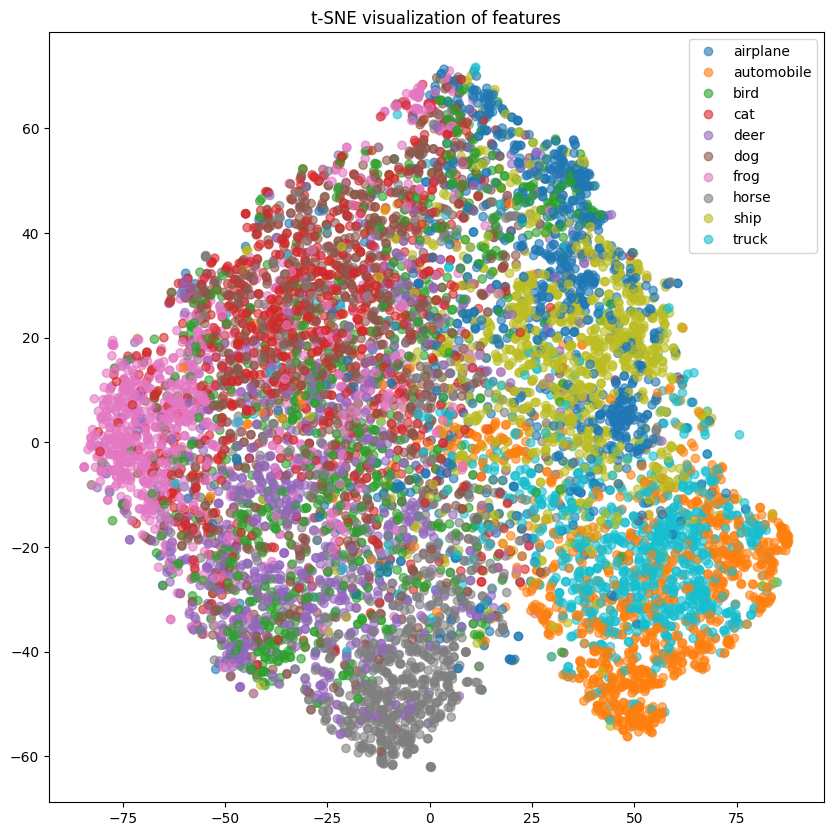

In [41]:
# Initialize lists to store features and labels
features_list = []
labels_list = []

# Initialize the model encoder on the correct device
model_encoder = MAE_Encoder_FeatureExtractor(model.encoder).to(device)

# Iterate over the validation DataLoader and extract features
for val_img, label in val_dataloader:
    val_img = val_img.to(device)
    
    with torch.no_grad():
        features = model_encoder(val_img)
        features = features[0, :, :]  # Only use the CLS token (represents the entire image in transformer models)

    # for i in range(len(features)):
    #     features_list.append(features[i])
    #     labels_list.append(label[i])

    # Extend lists with the entire batch
    features_list.extend(features)
    labels_list.extend(label)

# Stack the features and labels into tensors
features = torch.stack(features_list)
labels = torch.stack(labels_list)

# Retrieve class names from the dataset
class_names = val_dataset.classes

# Configure and visualize features using t-SNE with optional PCA
tsne_save_config = (folder_name, dataset_name, pca_mode)
utils.visualize_features(
    features, labels, class_names,
    tsne_save_config=tsne_save_config,
    n_components_tsne=2,
    pca_components=50
)

In [42]:
# Visualize the Predictions from a Single Batch (Components with low explained variance (%25 bottom))

In [50]:
dataset_name = "cifar10"
pca_mode = "bottom_25"
model_name = "vit-t-mae-pretrain.pt"
folder_name = f"../model/{dataset_name}/{pca_mode}"
model_path = f"{folder_name}/{model_name}"
model = torch.load(model_path, map_location='cpu')
model.eval()
device = utils.get_gpu() # get the gpu if available
utils.setup_seed(12345) # set seed
model.to(device)
# create a folder to save the model if it does not exist
folder_name = f"../images/model_results"
os.makedirs(folder_name, exist_ok=True)

Tesla V100-PCIE-32GB
Memory Usage:
Allocated: 3.0 GB
Cached:    5.5 GB
1 Number of Devices Exists


In [44]:
_, val_dataset_pca_mode = utils.extract_variance_components(cfg, train_dataset, val_dataset, device)
val_dataloader_pca_mode = torch.utils.data.DataLoader(val_dataset_pca_mode, 16, shuffle=False, num_workers=0)

60000it [00:13, 4576.33it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


625


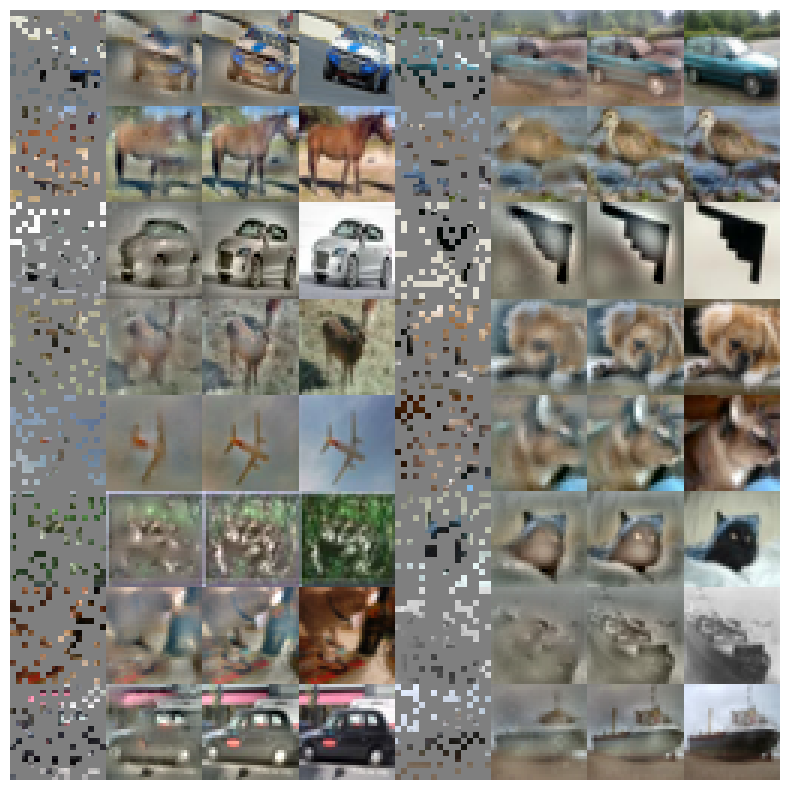

In [51]:
# Visiualize the random batch
total_batches = len(val_dataloader_pca_mode)
print(total_batches)
random_index = random.randint(0, total_batches - 1)

# Retrieve the random batch
for i, (batch, label) in enumerate(val_dataloader_pca_mode):
    if i == random_index:
        val_img = batch
        val_img_label = label
        break

val_img = val_img.to(device)
predicted_val_img, mask = model(val_img)
# MAE reconstruction pasted with visible patches
predicted_val_img = predicted_val_img * mask + val_img_label * (1 - mask) 

img = torch.cat([val_img * (1 - mask), predicted_val_img, val_img_label, val_img], dim=0)
img = rearrange(img, "(v h1 w1) c h w -> c (h1 h) (w1 v w)", w1=2, v=4)

img = (
    img.cpu().detach().numpy().transpose(1, 2, 0) + 1
) / 2  # Normalize to [0, 1] for display

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis("off")
# plt.show()
plt.savefig(f"{folder_name}/mae_visualize_bottom_25_perc.png")

In [52]:
# Visualize features using t-SNE for pretrained MAE with images to reconstract %25 bottom images

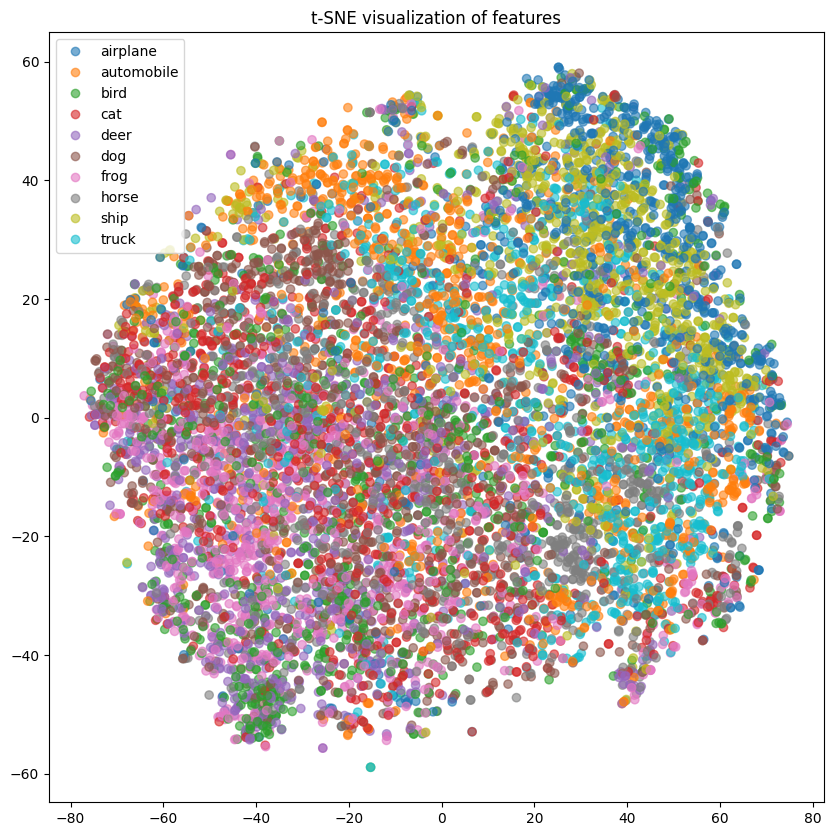

In [54]:
# Initialize lists to store features and labels
features_list = []
labels_list = []

# Initialize the model encoder on the correct device
model_encoder = MAE_Encoder_FeatureExtractor(model.encoder).to(device)

# Iterate over the validation DataLoader and extract features
for val_img, label in val_dataloader:
    val_img = val_img.to(device)
    
    with torch.no_grad():
        features = model_encoder(val_img)
        features = features[0, :, :]  # Only use the CLS token (represents the entire image in transformer models)

    # Extend lists with the entire batch
    features_list.extend(features)
    labels_list.extend(label)

# Stack the features and labels into tensors
features = torch.stack(features_list)
labels = torch.stack(labels_list)

# Retrieve class names from the dataset
class_names = val_dataset.classes

# Configure and visualize features using t-SNE with optional PCA
tsne_save_config = (folder_name, dataset_name, pca_mode)
utils.visualize_features(
    features, labels, class_names,
    tsne_save_config=tsne_save_config,
    n_components_tsne=2,
    pca_components=50
)